In [1]:
import numpy as np
from scipy.stats import norm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
cm = plt.get_cmap('plasma')

In [2]:
# Cubic spline GP covariance function
def GPK(x1, x2):
    v = np.minimum(x1[None, :], x2[:, None])
    return v ** 2 * 0.5 * np.abs(x1[None, :] - x2[:, None]) + v ** 3 / 3

In [3]:
# Zero intercept
def intercept(y, x):
    i = 0
    while y[i] < 0:
        i += 1
    r = y[i - 1] / (y[i - 1] - y[i])
    return x[i - 1] + r * (x[i] - x[i - 1]), i

In [4]:
def GP_step(x, y, Sigmas, beta, n, gamma, snr):
    # GP calculations
    K = GPK(x, x) + np.identity(len(x)) * snr ** 2 * x.max() ** 3
    Kinv = np.linalg.inv(K)
    H = np.ones((2, len(x)))
    H[1,:] = x
    B = np.linalg.inv(H @ Kinv @ H.T) @ H @ Kinv @ y
    alpha = Kinv @ (y - H.T @ B)
    
    # Useful quantities
    s2 = n / (n - 1)
    s = np.sqrt(s2)
    m = s2 * (Sigmas[:, None])
    Nb = norm.pdf((m - beta) / s)
    Phib = norm.cdf((m - beta) / s)
    
    a1 = Sigmas[:, None] / (n - 1) + gamma * (Phib * (B[0] + m * B[1]) + Nb * s * B[1])
    a1 = np.squeeze(a1)
    
    # x_i < beta terms
    alpha1 = alpha[x < beta]
    x1 = x[None, x < beta]
    a2 = gamma * ((m * Phib + s * Nb) * x1 ** 2 / 2 - Phib * x1 ** 3 / 6) @ alpha1

    # x_i >= beta terms
    alpha2 = alpha[x >= beta]
    x2 = x[None, x >= beta]
    Nx = norm.pdf((m - x2) / s)
    Phix = norm.cdf((m - x2) / s)

    aa1 = ((s ** 2 + m ** 2) * (Phib - Phix) + s * (beta + m) * Nb - s * (x2 + m) * Nx) * x2 / 2
    aa2 = -(s*(beta**2+m**2+beta*m+2*s2)*Nb - s*(x2**2+m**2+x2*m+2*s2)*Nx + (3*s2*m+m**3)*(Phib-Phix)) / 6
    aa3 = (m * Phix + s * Nx) * x2 ** 2 / 2 - Phix * x2 ** 3 / 6

    a3 = gamma * (aa1 + aa2 + aa3) @ alpha2

    return a1 + a2 + a3

In [5]:
def gittins(eff_hor, gamma=None, res=10, snr=0.001, sds=3, return_U=False):
    N = 2 * eff_hor # Run DP from double effective horizon
    if gamma is None:
        gamma = 1 - 1 / eff_hor
    lower = -np.sqrt(eff_hor)
    upper = sds * np.sqrt(eff_hor)
    num = int((upper - lower) * res)
    Sigmas = np.linspace(lower, upper, num)
    
    if return_U:
        U = np.zeros((N - 1, num)) # Matrix to store value functions. Range will not adapt if this is active
    
    # First DP step. U(Sigma, N)=Sigma/n(1-gamma) is linear in Sigma so compute U(Sigma, N-1) directly
    s = np.sqrt(N / (N - 1))
    m = Sigmas * s ** 2
    q = Sigmas * s
    val = Sigmas / (N - 1) + (m * norm.cdf(q) + s * norm.pdf(q)) * gamma / N / (1 - gamma) 
    
    if return_U:
        U[-1,:] = val # Store value function if needed
    
    betas = [] # Store 0-intercepts
    b = [] # b = -beta / n
    beta, i = intercept(val, Sigmas)
    
    # Approximate U(n) by a GP for all subsequent steps
    for n in tqdm(range(N-1, 1, -1)):
            
        x = Sigmas[max(i-4,0):] # Start a bit to the left of the 0-intercept from previous step
        y = val[max(i-4,0):num]
        
        # Remove values of Sigma larger than sds * sqrt(n)
        if not return_U:
            upper = sds * np.sqrt(n)
            num = int((upper - lower) * res)
            Sigmas = np.linspace(lower, upper, num)
        
        # Calculate U(Sigma, n-1)
        val = GP_step(x, y, Sigmas, beta, n, gamma, snr)
        
        if return_U:
            U[n-2,:] = val # Store value function if needed
        
        # Find new intercept & store beta and b
        beta, i = intercept(val, Sigmas)
        betas.append(beta)
        b.append(-beta / (n - 1))
    
    # Outputs
    if return_U:
        return np.array(betas[::-1]), np.array(b[::-1]), U
    else:
        return np.array(betas[::-1]), np.array(b[::-1])

In [6]:
betas10, b10, U10 = gittins(10, return_U=True)     # gamma = 0.9
betas20, b20, U20 = gittins(20, return_U=True)     # gamma = 0.95
betas50, b50, U50 = gittins(50, return_U=True)     # gamma = 0.98
betas100, b100, U100 = gittins(100, return_U=True) # gamma = 0.99

In [7]:
plt.rcParams.update({'font.size':12})

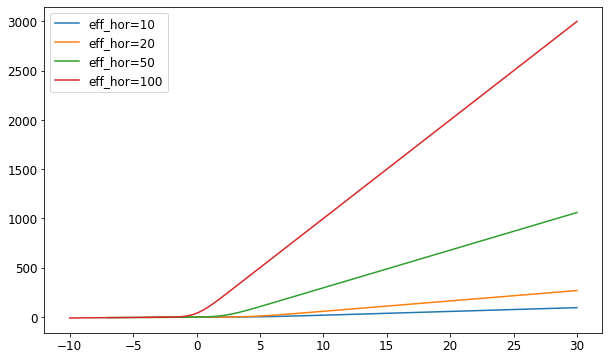

In [8]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(-int(np.sqrt(10)),30,U10.shape[1]), U10[0,:], label='eff_hor=10')
plt.plot(np.linspace(-int(np.sqrt(20)),30,U20.shape[1]), U20[0,:], label='eff_hor=20')
plt.plot(np.linspace(-int(np.sqrt(50)),30,U50.shape[1]), U50[0,:], label='eff_hor=50')
plt.plot(np.linspace(-int(np.sqrt(100)),30,U100.shape[1]), U100[0,:], label='eff_hor=100')
plt.legend()
plt.show()

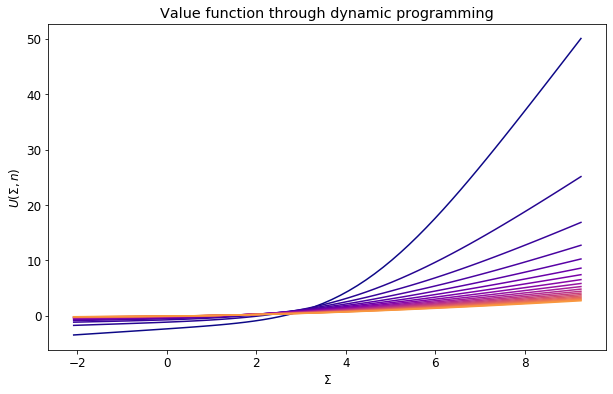

In [10]:
plt.figure(figsize=(10,6))
N=20
for i in range(N):
    plt.plot(np.linspace(-int(np.sqrt(20)),30,U20.shape[1])[10:70], U20[i,10:70], color=cm(0.8 * i / N))
plt.xlabel(r'$\Sigma$')
plt.ylabel(r'$U(\Sigma, n)$')
plt.title('Value function through dynamic programming')
plt.show()

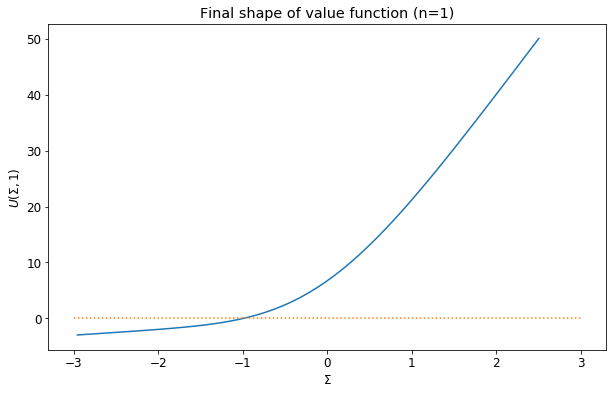

In [13]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(-np.sqrt(20),3*np.sqrt(20),U20.shape[1])[15:70], U20[0,15:70])
plt.plot([-3,3],[0,0], ':')
plt.xlabel(r'$\Sigma$')
plt.ylabel(r'$U(\Sigma, 1)$')
plt.title('Final shape of value function (n=1)')
plt.show()


In [12]:
U20.min()

-4.4721359392512126

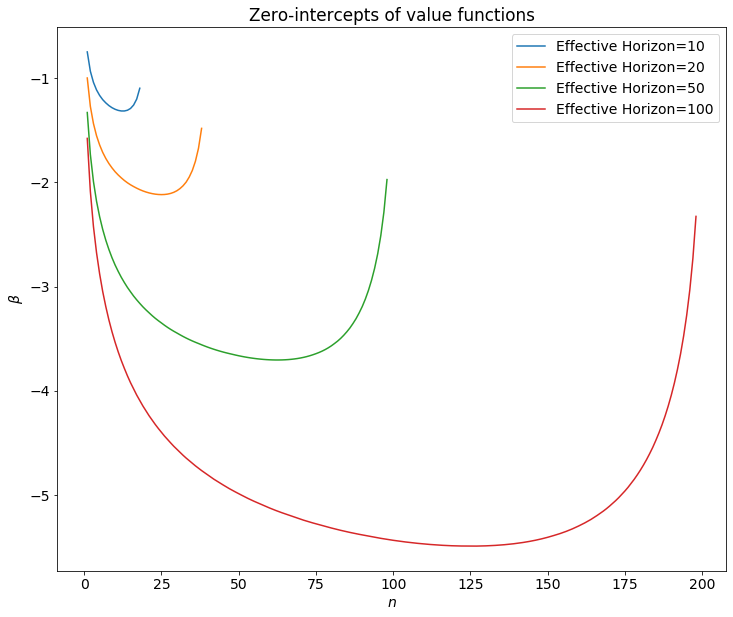

In [21]:
plt.figure(figsize=(12,10))
plt.rc('font', size=14)
plt.plot(list(range(1,19)), betas10, label='Effective Horizon=10')
plt.plot(list(range(1,39)), betas20, label='Effective Horizon=20')
plt.plot(list(range(1,99)), betas50, label='Effective Horizon=50')
plt.plot(list(range(1,199)), betas100, label='Effective Horizon=100')
plt.xlabel(r'$n$')
plt.ylabel(r'$\beta$')
plt.legend()
plt.title('Zero-intercepts of value functions')
plt.show()

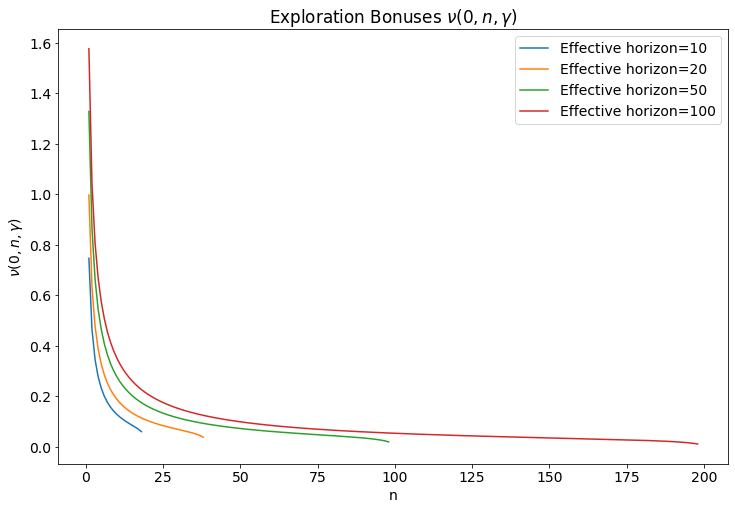

In [23]:
plt.figure(figsize=(12,8))
plt.rc('font', size=14)
plt.plot(list(range(1,19)), b10, label='Effective horizon=10')
plt.plot(list(range(1,39)), b20, label='Effective horizon=20')
plt.plot(list(range(1,99)), b50, label='Effective horizon=50')
plt.plot(list(range(1,199)), b100, label='Effective horizon=100')
#plt.plot(list(range(1,399)), b200, label='eff_hor=200')
plt.xlabel('n')
plt.ylabel(r'$\nu(0,n,\gamma)$')
plt.title('Exploration Bonuses ' + r'$\nu(0,n,\gamma)$')
plt.legend()
plt.show()

In [451]:
betas10f, b10f = gittins(10)    # gamma = 0.9
betas20f, b20f = gittins(20)    # gamma = 0.95
betas50f, b50f = gittins(50)    # gamma = 0.98
betas100f, b100f = gittins(100) # gamma = 0.99

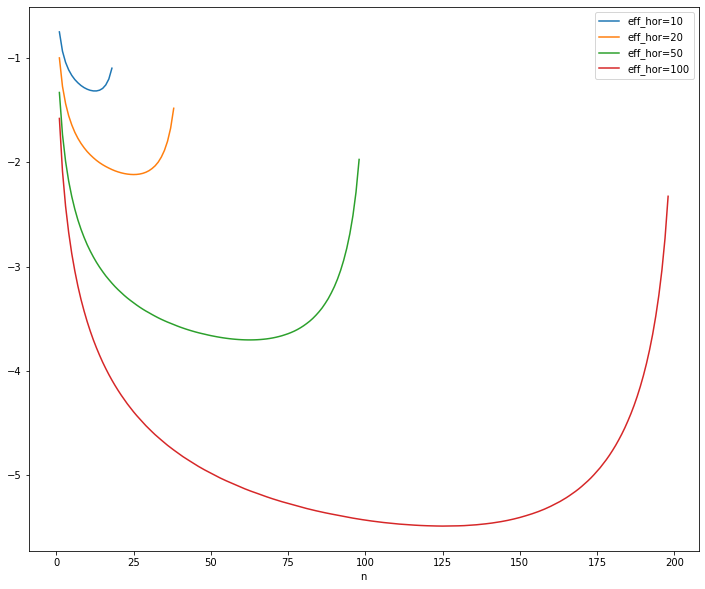

In [438]:
plt.figure(figsize=(12,10))
plt.plot(list(range(1,19)), betas10f, label='eff_hor=10')
plt.plot(list(range(1,39)), betas20f, label='eff_hor=20')
plt.plot(list(range(1,99)), betas50f, label='eff_hor=50')
plt.plot(list(range(1,199)), betas100f, label='eff_hor=100')
plt.xlabel('n')
plt.legend()
plt.show()

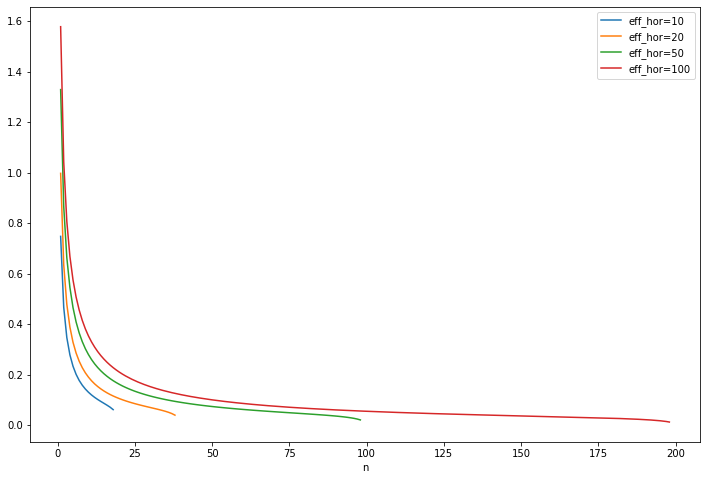

In [439]:
plt.figure(figsize=(12,8))
plt.plot(list(range(1,19)), b10f, label='eff_hor=10')
plt.plot(list(range(1,39)), b20f, label='eff_hor=20')
plt.plot(list(range(1,99)), b50f, label='eff_hor=50')
plt.plot(list(range(1,199)), b100f, label='eff_hor=100')
plt.xlabel('n')
plt.legend()
plt.show()

In [440]:
print(max([abs(b10[i]-b10f[i]) for i in range(len(b10))]))
print(max([abs(b20[i]-b20f[i]) for i in range(len(b20))]))
print(max([abs(b50[i]-b50f[i]) for i in range(len(b50))]))
print(max([abs(b100[i]-b100f[i]) for i in range(len(b100))]))

0.00021747447364395267
0.0002625942013956273
0.0004853603642246407
0.0011813180528936762


In [473]:
np.save('gittins_100', b100f)

In [502]:
np.save('gittins_200', b200)

In [474]:
betas1000, b1000 = gittins(1000)
np.save('gittins_1000', b1000)

In [495]:
betas500, b500 = gittins(500)
np.save('gittins_500', b500)

[-0.61312634] 0.6021792168973024


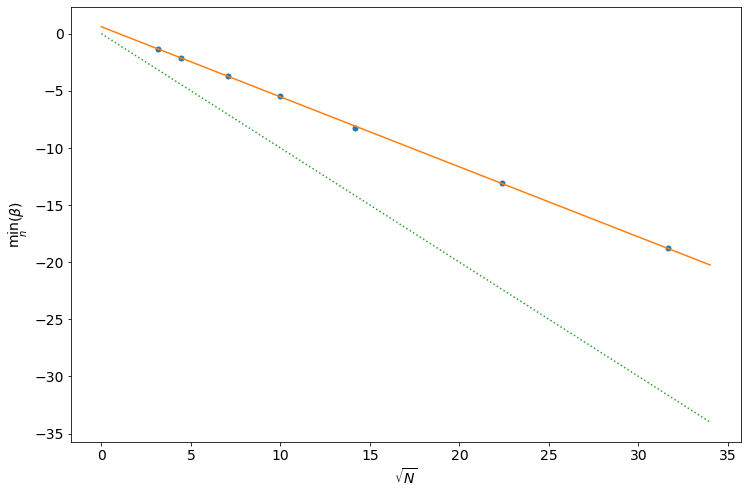

In [500]:
from sklearn.linear_model import LinearRegression

x = np.sqrt(np.array([10,20,50,100,200,500,1000]))[:, None]
y = np.array([min(b) for b in [betas10,betas20,betas50,betas100,betas200,betas500,betas1000]])

lr = LinearRegression()
lr.fit(x, y)
print(lr.coef_, lr.intercept_)

plt.figure(figsize=(12,8))
plt.rc('font', size=14)
plt.plot(x, y, '.', markersize=10)
plt.plot(np.arange(35), lr.coef_ * np.arange(35) + lr.intercept_)
plt.plot(np.arange(35), -np.arange(35), ':')
plt.xlabel(r'$\sqrt{N}$')
plt.ylabel(r'$\min_n(\beta)$')

plt.show()